Get word vectors from Glove

NN Model

In [8]:
import sys, os
from numpy import *
from matplotlib.pyplot import *
%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 100

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from misc import random_weight_matrix
random.seed(10)
print random_weight_matrix(3,5)

[[ 0.46994114 -0.83008197  0.23148553  0.43094097 -0.00258593]
 [-0.47666619 -0.52297046  0.45125243 -0.57311684 -0.71301636]
 [ 0.32105262  0.78530031 -0.85918681  0.02111762  0.54147539]]


In [10]:
import data_utils.utils as du
import data_utils.ner as ner
from nerwindow import full_report, eval_performance
from nerwindow import WindowMLP

In [11]:
wv, word_to_num, num_to_word = ner.load_wv('data/vocab.txt',
                                           'data/wvec.txt')

tagnames = ["O", "B", "I", "L", "U"]
num_to_tag = dict(enumerate(tagnames))
tag_to_num = du.invert_dict(num_to_tag)

vissualize the pre-trained word vectors

Tune parameters here

In [12]:
wsize = 5
hidden_dim = 100
reg = 0.001
alpha = 0.01
nepoch = 5
k = 5  

In [13]:
pad = (wsize - 1)/2

X_train, y_train, words_train = du.generateData('data/train_small', word_to_num, tag_to_num, wsize)
X_dev, y_dev, words_dev = du.generateData('data/dev_small', word_to_num, tag_to_num, wsize)

In [ ]:
def isCapital(x):
    if len(x) > 0:
        return x[0].isupper()
    return false

def capitalFeature(words):
    fvec = array([isCapital(ww) for ww in words]).astype(int)
    return fvec

cap_train = capitalFeature(words_train)
cap_dev = capitalFeature(words_dev)

In [ ]:
print cap_train[:50]

In [22]:
N = nepoch * len(y_train)

random.seed(10) 

l = len(y_train)

# idxiter1 = [i for j in range(nepoch) for i in range(l)]
# idxiter2 = [i for i in list(random.choice(range(l), N))]
idxiter = [list(random.choice(l, k)) for i in xrange(N/k)]
# idxiter0 = [list(random.choice(range(l), k)) for i in range(500)]

clf = WindowMLP(wv, windowsize=wsize, dims=[None, hidden_dim, 5],
                reg=reg, alpha=alpha)

In [24]:
clf.train_sgd(X_train, y_train,
              idxiter, 
              alphaiter=None,
              printevery=10000, 
              costevery=10000,
              devidx=None)

Begin SGD...
  Seen 0 in 0.00 s
  [0]: mean loss 0.395981
  Seen 10000 in 15.29 s
  [10000]: mean loss 0.297982
  Seen 20000 in 28.88 s
  [20000]: mean loss 0.246273
  Seen 30000 in 42.36 s
  [30000]: mean loss 0.229553
  Seen 40000 in 55.85 s
  [40000]: mean loss 0.233552
  Seen 50000 in 69.39 s
  [50000]: mean loss 0.215783
  Seen 60000 in 83.01 s
  [60000]: mean loss 0.205105
  Seen 70000 in 96.79 s
  [70000]: mean loss 0.19919
  Seen 80000 in 110.30 s
  [80000]: mean loss 0.195348
  Seen 90000 in 123.87 s
  [90000]: mean loss 0.188556
  [95230]: mean loss 0.186812
SGD complete: 95230 examples in 131.73 seconds.


[(0, 0.39598063113858417),
 (10000, 0.29798168141247661),
 (20000, 0.24627308774730169),
 (30000, 0.22955312162894861),
 (40000, 0.23355178983370167),
 (50000, 0.21578269599495156),
 (60000, 0.20510476374289768),
 (70000, 0.19919001478698728),
 (80000, 0.19534781607361984),
 (90000, 0.18855553643539111),
 (95230, 0.18681152970778581)]

In [69]:
y_pred = clf.predict(X_train)
eval_performance(y_train, y_pred, tagnames)

=== Performance (omitting 'O' class) ===
Mean precision:  66.20%
Mean recall:     58.87%
Mean F1:         62.07%


In [25]:
# Predict labels on the dev set
yp = clf.predict(X_dev)
# Save predictions to a file, one per line
ner.save_predictions(yp, "dev.predicted")

In [26]:
from nerwindow import full_report, eval_performance
full_report(y_dev, yp, tagnames) # full report, helpful diagnostics
eval_performance(y_dev, yp, tagnames) # performance: optimize this F1

             precision    recall  f1-score   support

          O       0.93      0.97      0.95      8559
          B       0.36      0.38      0.37       255
          I       0.31      0.13      0.19       135
          L       0.38      0.25      0.30       255
          U       0.45      0.11      0.17       328

avg / total       0.87      0.89      0.88      9532

=== Performance (omitting 'O' class) ===
Mean precision:  39.03%
Mean recall:     21.99%
Mean F1:         26.02%


Visualization

In [29]:
import matplotlib.pyplot as plt
def visual(wordv, numWords, num_to_word):
    visualizeVecs = wordv[:numWords]
    temp = (visualizeVecs - np.mean(visualizeVecs, axis=0))
    covariance = 1.0 / numWords * temp.T.dot(temp)

    U,S,V = np.linalg.svd(covariance)
    coord = temp.dot(U[:,0:2]) 

    for i in xrange(numWords):
        plt.text(coord[i,0], coord[i,1], num_to_word[i], bbox=dict(facecolor='green', alpha=0.1))

    plt.xlim((np.min(coord[:,0]), np.max(coord[:,0])))
    plt.ylim((np.min(coord[:,1]), np.max(coord[:,1])))

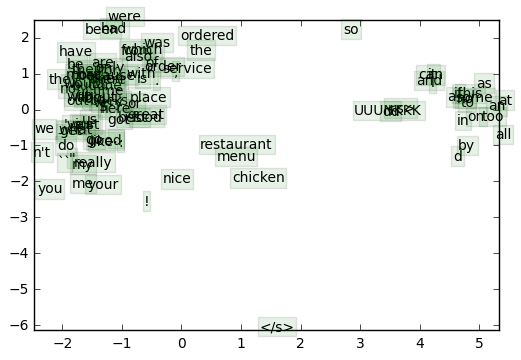

In [30]:
# visual(wv, 100, num_to_word)
visual(clf.sparams.L, 100, num_to_word)

Keras

In [16]:
wsize = 5
hidden_dim = 100
reg = 0.001
alpha = 0.01
nepoch = 5
k = 5  
inputDim = wsize * 50

In [14]:
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from keras.regularizers import l2

Xt = wv[X_train]
Xd = wv[X_dev]
X_t = Xt.reshape(Xt.shape[0], Xt.shape[1]*Xt.shape[2])
X_d = Xd.reshape(Xd.shape[0], Xd.shape[1]*Xd.shape[2])
Y_t = np_utils.to_categorical(y_train, 5)
Y_d = np_utils.to_categorical(y_dev, 5)
print X_t.shape
print Y_t.shape

(95230, 250)
(95230, 5)


In [12]:
model = Sequential()
inputDim = wsize * 50
model.add(Dense(input_dim=inputDim, output_dim=hidden_dim, init="uniform"))
model.add(Activation("tanh"))
model.add(Dense(input_dim=hidden_dim, output_dim=5, init="uniform"))
model.add(Activation("softmax"))
# model.add(Dense(64, 64, W_regularizer = l2(reg)))
model.compile(loss='categorical_crossentropy', optimizer='sgd')
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=alpha, momentum=0, nesterov=False))

In [ ]:
model.fit(X_t, Y_t, nb_epoch=nepoch, batch_size=k)

LSTM

In [ ]:
# keras.layers.recurrent.LSTM(input_dim, output_dim=128, 
#         init='glorot_uniform', inner_init='orthogonal', 
#         activation='tanh', inner_activation='hard_sigmoid',
#         weights=None, truncate_gradient=-1, return_sequences=False)

In [20]:
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM

model = Sequential()
model.add(Embedding(inputDim, 256))
model.add(LSTM(256, 128, activation='sigmoid', inner_activation='hard_sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(128, 5))
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

INFO (theano.gof.compilelock): Refreshing lock /Users/tianxin/.theano/compiledir_Darwin-13.4.0-x86_64-i386-64bit-i386-2.7.5-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /Users/tianxin/.theano/compiledir_Darwin-13.4.0-x86_64-i386-64bit-i386-2.7.5-64/lock_dir/lock


In [21]:
model.fit(X_t, Y_t, batch_size=16, nb_epoch=10)
score = model.evaluate(X_d, Y_d, batch_size=16)

Epoch 0
Epoch 0
54896/95230 [================>.............] - ETA: 2785s - loss: 0.4808

KeyboardInterrupt: 